In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
import community as community_louvain
import networkx as nx

In [26]:
df = pd.read_csv('/Users/noimotbakare/Dropbox/Fraud_Payments/data/fraud_payment_data', sep=',', header=0)


In [27]:
#Converting time into a Datetime object
df['timestamp'] = pd.to_datetime(df['Time_step'])
#Removing redudant columns
df=df.drop('Time_step',axis=1)
df=df.drop('Sender_lob',axis=1)
#df=df.drop('Sender_Sector',axis=1)
#Apparently some transactions amounted to zero dollars. None of them were fraudulent, so I've removed them.
#=====>Many credit card fraud datasets contain transactions with an amount of zero, which are actually merchants verifying that a card is active and functional.
#While these are not fraudulent, they are part of a regular transaction pattern.
#Removing them would eliminate a significant piece of normal customer behavior, which the model needs to understand. 
#df=df[df.USD_amount>0]
#df

In [28]:
#Engineering Features that do not rely on Statistics before train test split

#First Digit 
df['USD_amount'] = pd.to_numeric(df['USD_amount'], errors='coerce')
#Extract the first digit from each amount
df['first_digit'] = df['USD_amount'].astype(str).str.strip().str[0]
df = df[df['first_digit'].str.isdigit()]
df['first_digit'] = df['first_digit'].astype(int)

#Last Digit 
#Extract the last digit after decimal USD_amount
df['last_digit_after_dec'] = df['USD_amount'].astype(str).str.split('.').str[1].str[-1]
df = df[df['last_digit_after_dec'].str.isdigit()]
df['last_digit_after_dec'] = df['last_digit_after_dec'].astype(int)

In [30]:
#we will take 70% of our dataset as training data, 15% as a validation set and use the remaining 15% as our test set.
cutoff = round(0.7*len(df)) 
df_train = df.head(cutoff)
not_train =  df.tail(len(df)-cutoff)
cutoff2 = round(0.5*len(df_train))
df_val = df.head(cutoff2)
df_test = df.tail(len(not_train)-cutoff2)

In [31]:
# Make sure that the distribution of fraudulent/legitimate transactions are consistent across the three different sets.
print('The distribution of fraud for the train data is:\n', df_train['Label'].value_counts(normalize=True))
print('The distribution of fraud for the validation set is:\n', df_val['Label'].value_counts(normalize=True))
print('The distribution of fraud for the test set is:\n', df_test['Label'].value_counts(normalize=True))

The distribution of fraud for the train data is:
 Label
0    0.978931
1    0.021069
Name: proportion, dtype: float64
The distribution of fraud for the validation set is:
 Label
0    0.979411
1    0.020589
Name: proportion, dtype: float64
The distribution of fraud for the test set is:
 Label
0    0.979412
1    0.020588
Name: proportion, dtype: float64


In [ ]:
#from sklearn.base import BaseEstimator, TransformerMixin
# import networkx as nx 

class FraudFeatureEngineer(BaseEstimator, TransformerMixin):

    def __init__(self, add_transaction_features=True,
                  add_sector_encoding=True, 
                  add_graph_features=True
                  ):
        


        #Only include the flags you are currently using in the fit method
        self.add_transaction_features = add_transaction_features
        self.add_sector_encoding = add_sector_encoding
        self.add_graph_features = add_graph_features

        #Attributes to be learned during fit() initialized
        self.sender_count_map = None
        self.sender_mean_map = None
        self.sender_std_map = None
        self.bene_count_map = None
        self.bene_mean_map = None
        self.bene_std_map = None
        self.country_fraud_ratio_map = None
        self.sender_avg_time_map = None

        #Defaults in case of missing values 
        self.global_country_ratio_default = 0.0
        self.sector_target_map = None 
        self.global_time_diff_default = 0.0 

        #Graph Features 
        self.pagerank_map = None
        self.in_degree_map = None
        self.out_degree_map = None
        self.clustering_map = None
        self.louvain_unweighted_map = None
        self.louvain_weighted_map = None

        self.community_fraud_rate_map = None
        self.global_community_fraud_rate_ = 0.0

    # FIT METHOD: Learns the statistics ONLY from the training data (X)
    def fit(self, X, y=None):
        
      #Merging label (target) for calculations inside the transformer
        if y is not None and 'Label' not in X.columns:
            X = X.copy()
            X['Label'] = y #
        #=====================
        #Transaction Features
        #====================
        if self.add_transaction_features:
            quick = X[X['Transaction_Type'] == 'QUICK-PAYMENT']
            
            #Quick Payment Transaction Features
            self.sender_count_map = quick.groupby('Sender_Account')['USD_amount'].count()
            self.sender_mean_map = quick.groupby('Sender_Account')['USD_amount'].mean()
            self.sender_std_map = quick.groupby('Sender_Account')['USD_amount'].std()

            self.bene_count_map = quick.groupby('Bene_Account')['USD_amount'].count()
            self.bene_mean_map = quick.groupby('Bene_Account')['USD_amount'].mean()
            self.bene_std_map = quick.groupby('Bene_Account')['USD_amount'].std()

            #Country Fraud Ratio (Note to self: Target Leakage SAFE because we only FIT on X_train)
            fraud = X[X['Label'] == 1]
            total_count = X.groupby('Sender_Country')['Label'].count()
            fraud_count = fraud.groupby('Sender_Country')['Label'].count().fillna(0)
            self.country_fraud_ratio_map = fraud_count / total_count
            self.global_country_ratio_default = fraud_count.sum() / total_count.sum() # Default for new countries

            #Time Difference Feature
            X_sorted = X.sort_values(['Sender_Account', 'timestamp'])

            # diff() and dt.total_seconds() need pd dttm objects
            X_sorted['time_diff'] = X_sorted.groupby('Sender_Account')['timestamp'].diff().dt.total_seconds()
            self.sender_avg_time_map = X_sorted.groupby('Sender_Account')['time_diff'].mean()
            self.global_time_diff_default = self.sender_avg_time_map.median() 
        #Sector Feature
        #=====================   
            #Sector Encoding 
        if self.add_sector_encoding:
            # missing as category
            X['Sender_Sector'] = X['Sender_Sector'].fillna(-1)  
            fraud_rate_by_sector = X.groupby('Sender_Sector')['Label'].mean()
            self.sector_target_map_ = fraud_rate_by_sector
            #Defaul value if sector is not seen in the training set
            self.global_fraud_rate_ = X['Label'].mean()  
       
        #====================
        #Graph Feature 
        #=====================
        if self.add_graph_features:
            #Graphs (Directed and Undirected)
            G_dir = nx.from_pandas_edgelist(
                X, source='Sender_Account', target='Bene_Account', 
                edge_attr='USD_amount', create_using=nx.DiGraph() 
            )
            G_undir = G_dir.to_undirected()
            
            #Calculate and Store Directed Features
            self.in_degree_map = pd.Series(dict(G_dir.in_degree()), name='in_degree')
            self.out_degree_map = pd.Series(dict(G_dir.out_degree()), name='out_degree')
            self.pagerank_map = pd.Series(nx.pagerank(G_dir, weight='USD_amount'), name='pagerank')

            #Calculate and Store Undirected Features
            self.clustering_map = pd.Series(nx.clustering(G_undir), name='clustering_coeff')
            self.louvain_unweighted_map = community_louvain.best_partition(G_undir)
            self.louvain_weighted_map = community_louvain.best_partition(G_undir, weight='USD_amount')

            #Calculate Louvain Community Fraud Rate

            #Weighted
            X['Sender_Community_ID'] = X['Sender_Account'].map(self.louvain_weighted_map).fillna(-1)

            #Stats for Smoothing
            community_stats = X.groupby('Sender_Community_ID').agg(
                community_size=('Sender_Account', 'count'), 
                fraud_rate=('Label', 'mean'),
                fraud_tx_count=('Label', 'sum') # <-- Need the sum for the numerator
            ).reset_index()

            #Global Metrics (The Prior)
            self.global_community_fraud_rate_ = X['Label'].mean() # This is the global average rate


            #Smoothing Factor (alpha)
            # Using the 25th percentile of community sizes as the smoothing strength
            alpha = community_stats['community_size'].quantile(0.25)

            #Apply Bayesian Smoothing
            community_stats['Smoothed_Fraud_Rate'] = (
            (alpha * self.global_community_fraud_rate_) + community_stats['fraud_tx_count']
            ) / ( alpha + community_stats['community_size'] )

            #smoothed rate map
            self.community_fraud_rate_map = community_stats.set_index('Sender_Community_ID')['Smoothed_Fraud_Rate']



       # print("Fit method completed successfully.")
        return self

 
    #=============
    #TRANSFORM
    #=============

    #TRANSFORM METHOD: Applies the learned statistics to create the new features
    def transform(self, X):
        X_transformed = X.copy()
        
        #Helper function for merging and imputing (Applies to all maps)
        def apply_map(df, map_series, on_col, new_col_name, default_val):
            #convert to dataframe
            map_df = map_series.to_frame(name=new_col_name)
            
            #Merge the feature
            df = df.merge(map_df, on=on_col, how='left')
            
            #Impute (Fill NaNs with the global default from the training set)
            df[new_col_name].fillna(default_val, inplace=True)
            return df

        if self.add_transaction_features:
            #Apply all quick payment maps
            X_transformed = apply_map(X_transformed, self.sender_count_map, 'Sender_Account', 'Sender_quick_count', 0)
            X_transformed = apply_map(X_transformed, self.sender_mean_map, 'Sender_Account', 'Sender_quick_mean', 0)
            X_transformed = apply_map(X_transformed, self.sender_std_map, 'Sender_Account', 'Sender_quick_std', 0)
            
            X_transformed = apply_map(X_transformed, self.bene_count_map, 'Bene_Account', 'Bene_quick_count', 0)
            X_transformed = apply_map(X_transformed, self.bene_mean_map, 'Bene_Account', 'Bene_quick_mean', 0)
            X_transformed = apply_map(X_transformed, self.bene_std_map, 'Bene_Account', 'Bene_quick_std', 0)
            
            #Apply Country Fraud Ratio
            X_transformed = apply_map(X_transformed, self.country_fraud_ratio_map, 'Sender_Country', 'Country_Fraud_Ratio', self.global_country_ratio_default)
            
            #Apply Sender Avg Time (requires re-sorting if weyou use the diff method, simpler to merge pre-calculated mean)
            X_transformed = apply_map(X_transformed, self.sender_avg_time_map, 'Sender_Account', 'Sender_Avg_Time_Diff', self.global_time_diff_default)

    
        if self.add_sector_encoding:
            X_transformed['Sender_Sector'] = X_transformed['Sender_Sector'].fillna(-1)
            X_transformed['Sender_Sector_target_enc'] = X_transformed['Sender_Sector'].map(self.sector_target_map_)
            X_transformed['Sender_Sector_target_enc'].fillna(self.global_fraud_rate_, inplace=True)


        if self.add_graph_features:
            def apply_graph_map_pair(df, map_series, map_name, default_val):
                # Apply map to SENDER
                df[f'Sender_{map_name}'] = df['Sender_Account'].map(map_series).fillna(default_val)
                # Apply map to BENEFACTOR
                df[f'Bene_{map_name}'] = df['Bene_Account'].map(map_series).fillna(default_val)
                return df
            
            #Apply all structural features (Default usually 0 for centrality features) -- ???
            X_transformed = apply_graph_map_pair(X_transformed, self.pagerank_map, 'pagerank', 0)
            X_transformed = apply_graph_map_pair(X_transformed, self.in_degree_map, 'in_degree', 0)
            X_transformed = apply_graph_map_pair(X_transformed, self.out_degree_map, 'out_degree', 0)
            X_transformed = apply_graph_map_pair(X_transformed, self.clustering_map, 'clustering_coeff', 0)

            # Apply Weighted Louvain Community IDs (Default is -1 for new accounts) (I do use this in fraud rate calculations)
            X_transformed['Sender_Community_ID_W'] = X_transformed['Sender_Account'].map(self.louvain_weighted_map).fillna(-1)
            X_transformed['Bene_Community_ID_W'] = X_transformed['Bene_Account'].map(self.louvain_weighted_map).fillna(-1)


            #Apply Unweighted Louvain Community IDs 
            X_transformed['Sender_Community_ID_UW'] = X_transformed['Sender_Account'].map(self.louvain_unweighted_map).fillna(-1)
            X_transformed['Bene_Community_ID_UW'] = X_transformed['Bene_Account'].map(self.louvain_unweighted_map).fillna(-1)
            
            # Apply the New Community Fraud Rate Feature!
            X_transformed['Community_Fraud_Rate'] = (
                X_transformed['Sender_Community_ID_W']
                .map(self.community_fraud_rate_map)
                .fillna(self.global_community_fraud_rate_) # Impute with global training mean
            )

        return X_transformed
    

In [ ]:

fe = FraudFeatureEngineer(
    add_transaction_features=True,
    add_sector_encoding=True,
    add_graph_features=True
)


#Transformer learns the relationship from the training data 
fe.fit(df_train)
#FE training set - adding colums 
df_train_transformed = fe.transform(df_train)
#Applying same features to the validation set
df_val_transformed = fe.transform(df_val)
#Applying same feature engineering to test set
df_test_transformed = fe.transform(df_test)

/var/folders/4z/15wr09ws2bv_y9y731bmm5540000gn/T/ipykernel_34613/2007547687.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sender_Sector'] = X['Sender_Sector'].fillna(-1)  # Treat missing as category
/var/folders/4z/15wr09ws2bv_y9y731bmm5540000gn/T/ipykernel_34613/2007547687.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sender_Community_ID'] = X['Sender_Account'].map(self.louvain_weighted_map).fillna(-1)


Fit method completed successfully.


/var/folders/4z/15wr09ws2bv_y9y731bmm5540000gn/T/ipykernel_34613/2007547687.py:163: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[new_col_name].fillna(default_val, inplace=True)
/var/folders/4z/15wr09ws2bv_y9y731bmm5540000gn/T/ipykernel_34613/2007547687.py:163: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

STOP - STILL WORKING ON THE THINGS BELOW! 

In [ ]:
#Looking at the variables to determine which features to drop
df_train_transformed.columns

Index(['Transaction_Id', 'Sender_Id', 'Sender_Account', 'Sender_Country',
       'Sender_Sector', 'Sender_lob', 'Bene_Id', 'Bene_Account',
       'Bene_Country', 'USD_amount', 'Label', 'Transaction_Type', 'timestamp',
       'first_digit', 'last_digit_after_dec', 'Sender_Community_ID',
       'Sender_quick_count', 'Sender_quick_mean', 'Sender_quick_std',
       'Bene_quick_count', 'Bene_quick_mean', 'Bene_quick_std',
       'Country_Fraud_Ratio', 'Sender_Avg_Time_Diff',
       'Sender_Sector_target_enc', 'Sender_pagerank', 'Bene_pagerank',
       'Sender_in_degree', 'Bene_in_degree', 'Sender_out_degree',
       'Bene_out_degree', 'Sender_clustering_coeff', 'Bene_clustering_coeff',
       'Sender_Community_ID_W', 'Bene_Community_ID_W',
       'Sender_Community_ID_UW', 'Bene_Community_ID_UW',
       'Community_Fraud_Rate'],
      dtype='object')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [ ]:
#Define Column Groups for Preprocessing
# All numerical columns that need standard scaling and imputation
Numerical_Features = ['Sender_Sector','USD_amount','Label','timestamp','first_digit','last_digit', 'Sender_Community_ID',
                       'Sender_quick_count', 'Sender_quick_mean', 'Sender_quick_std', 'Bene_quick_count', 'Bene_quick_mean']

In [37]:
df_train_transformed.info()
# correlation_matrix = df_train_transformed.corr()

# print("Correlation Matrix (Top 5 rows/cols):")
# print(correlation_matrix.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048724 entries, 0 to 1048723
Data columns (total 37 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   Transaction_Id            1048724 non-null  object        
 1   Sender_Id                 895425 non-null   object        
 2   Sender_Account            895425 non-null   object        
 3   Sender_Country            895425 non-null   object        
 4   Sender_Sector             1048724 non-null  float64       
 5   Bene_Id                   897775 non-null   object        
 6   Bene_Account              897775 non-null   object        
 7   Bene_Country              897775 non-null   object        
 8   USD_amount                1048724 non-null  float64       
 9   Label                     1048724 non-null  int64         
 10  Transaction_Type          1048724 non-null  object        
 11  timestamp                 1048724 non-null  dateti

In [42]:
df_train_transformed.columns[df_train_transformed.isna().sum() > 0]


Index(['Sender_Id', 'Sender_Account', 'Sender_Country', 'Bene_Id',
       'Bene_Account', 'Bene_Country'],
      dtype='object')

In [48]:
cols = [
    'Label','USD_amount','first_digit', 'last_digit_after_dec', 'Sender_Community_ID',
    'Sender_quick_count', 'Sender_quick_mean', 'Sender_quick_std',
    'Bene_quick_count', 'Bene_quick_mean', 'Bene_quick_std',
    'Country_Fraud_Ratio', 'Sender_Avg_Time_Diff',
    'Sender_Sector_target_enc', 'Sender_pagerank', 'Bene_pagerank',
    'Sender_in_degree', 'Bene_in_degree', 'Sender_out_degree',
    'Bene_out_degree',
      #'Sender_clustering_coeff', 'Bene_clustering_coeff',
    'Sender_Community_ID_W', 'Bene_Community_ID_W',
    'Sender_Community_ID_UW', 'Bene_Community_ID_UW',
    'Community_Fraud_Rate'
]

corr_matrix = df_train_transformed[cols].corr()
corr_matrix

,Label,USD_amount,first_digit,last_digit_after_dec,Sender_Community_ID,Sender_quick_count,Sender_quick_mean,Sender_quick_std,Bene_quick_count,Bene_quick_mean,...,Bene_pagerank,Sender_in_degree,Bene_in_degree,Sender_out_degree,Bene_out_degree,Sender_Community_ID_W,Bene_Community_ID_W,Sender_Community_ID_UW,Bene_Community_ID_UW,Community_Fraud_Rate
Label,1.000000,0.086386,0.006580,0.000879,0.003736,0.015748,0.027492,0.019156,0.020951,0.035390,...,0.010045,-0.004335,0.010040,-0.004353,0.010046,0.003736,-0.003109,0.005075,-0.002130,0.054179
USD_amount,0.086386,1.000000,0.271795,0.000441,-0.007728,-0.250442,-0.211452,-0.125675,0.067624,0.227828,...,-0.000185,0.011705,-0.000286,0.011405,0.000113,-0.007728,0.000167,-0.007801,-0.000546,0.012681
first_digit,0.006580,0.271795,1.000000,-0.001268,-0.011146,0.062870,0.105004,0.046105,-0.002175,0.000627,...,0.016371,0.018774,0.016377,0.018851,0.016286,-0.011146,-0.009128,-0.011205,-0.009735,0.018025
last_digit_after_dec,0.000879,0.000441,-0.001268,1.000000,-0.000924,-0.001238,-0.002171,-0.001266,0.000675,0.001078,...,-0.000534,0.000063,-0.000534,0.000062,-0.000533,-0.000924,-0.000275,-0.000735,-0.000185,0.000040
Sender_Community_ID,0.003736,-0.007728,-0.011146,-0.000924,1.000000,0.317162,0.343520,0.213778,0.022550,-0.133460,...,0.086210,-0.532684,0.086294,-0.532660,0.085932,1.000000,0.548701,0.911773,0.473229,-0.554303
Sender_quick_count,0.015748,-0.250442,0.062870,-0.001238,0.317162,1.000000,0.562155,0.401538,0.131004,-0.223512,...,0.144716,-0.579194,0.144891,-0.578802,0.144191,0.317162,-0.071940,0.328327,-0.066459,-0.525093
Sender_quick_mean,0.027492,-0.211452,0.105004,-0.002171,0.343520,0.562155,1.000000,0.661556,0.047106,-0.159915,...,0.154228,-0.625898,0.154386,-0.625702,0.153723,0.343520,-0.075012,0.345457,-0.077408,-0.555247
Sender_quick_std,0.019156,-0.125675,0.046105,-0.001266,0.213778,0.401538,0.661556,1.000000,0.035052,-0.062536,...,0.096369,-0.383094,0.096472,-0.382945,0.096057,0.213778,-0.044492,0.217934,-0.043146,-0.342810
Bene_quick_count,0.020951,0.067624,-0.002175,0.000675,0.022550,0.131004,0.047106,0.035052,1.000000,0.450075,...,-0.269695,-0.047701,-0.269684,-0.047701,-0.269750,0.022550,0.139221,0.027464,0.146931,-0.048360
Bene_quick_mean,0.035390,0.227828,0.000627,0.001078,-0.133460,-0.223512,-0.159915,-0.062536,0.450075,1.000000,...,-0.342857,0.253421,-0.342979,0.253117,-0.342535,-0.133460,0.184610,-0.136037,0.186827,0.221167


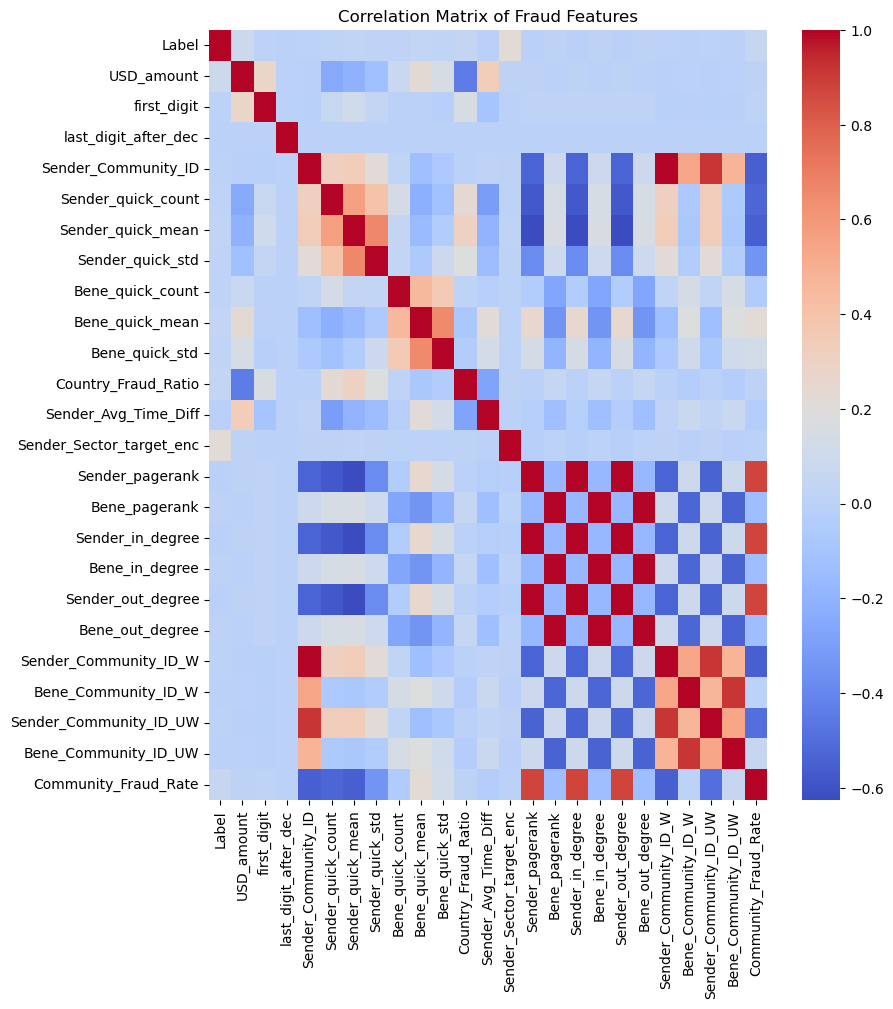

In [57]:


plt.figure(figsize=(9,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Fraud Features")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
